# Распространение тепла
# Кацуба Кирилл БПМ213
# Вариант 14
<img src="var_14.png" width=600/>

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования



**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import scipy.signal as signal
import time
from numba import njit, prange

Проинициализируем глобальные для нашей задачи константы:
1. Коеффициенты диффузии D0, D1
2. Размеры пластины для варианта 14
3. Уравнение мощности источников тепла и соотвествующие константы
4. Время моделирования

In [2]:
D0 = 1.0 # коеффициент диффузии основного материала (синий)
D1 = 0.01 # коеффициент диффузии включений (белый)

L = 60 # метры (пластина имеет форму квадрата, поэтому достаточно одного измерения)

def power_equation(theta: int, p: int, t:int) -> np.array:
    """
    Функция задающая уравнение мощности источников тепла:
    theta, p - параметры, относящиеся к конкретному источнику
    t - момент времени
    """
    return (p * (np.sin(2 * np.pi * t / theta) + 1))

p0, theta0 = 100, 43 # источник 0
p1, theta1 = 100, 77 # источник 1

t = 600.0

Также, напишем функцию для определения абсолютной теплоизоляции на ребрах и фиксированной темепературы на ребрах.$$$$
Граничное условие в виде абсолютной теплоизоляции означает, что через заданную грань нет потока тепла, а это достижимо, если температура в ячейках грани и прилегающим к ним ячейкам одинаковая:

То есть, для нашей задачи $x = L$: $T^{n}_{N-1,j} = T^{n}_{N-2,j}$,
для $y = L$: $T^{n}_{i,N-1} = T^{n}_{i,N-2}$.

In [3]:
def abs_thermal_insulation(T: np.ndarray):
    """
    Абсолютная теплоизоляция на ребрах
    T - поле температур
    """
    T[:, -1, :] = T[:, -2, :] # y = 60
    T[:, :, -1] = T[:, :, -2] # x = 60

def fixed_temp(T: np.ndarray):
    """
    Фиксированная темепература на ребрах
    T - поле температур
    """
    T[:, 0, :] = 0 # x = 0
    T[:, :, 0] = 0 # y = 0

Необходимо решить задачу для каждого N $\in [60,120,240,480,960]$. Где N x N - размер поля температур.

## Подготовка к решению (само решение задчи начинается ниже, где написано Основная задача)
 Сперва введем необходимые нам функции и переменные для простой задачи, когда N = 60. А затем напишем функцию для произвольного N.

In [4]:
N = 60
# Инициализируем поле температур T,
# в момент времени t = 0 T = 0
T = np.zeros((2, N, N))

# шаг по карте
dx = L / N

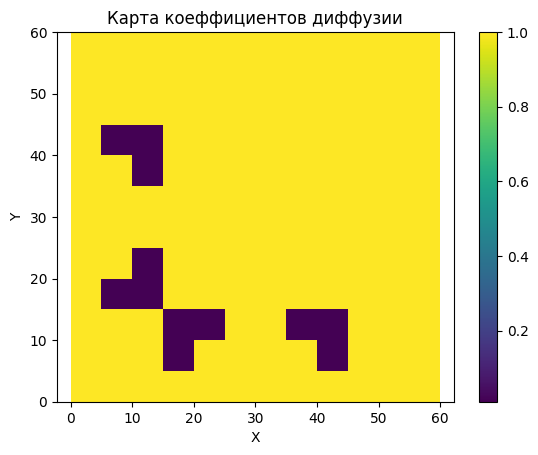

In [5]:
# карта коеффициентов диффузии
Dij = np.full((N, N), D0)

# шаг по длине и высоте белых полей
# они имеют форму квадрата, поэтому достаточно одного измерения
hx = int(10 / dx)

# коеффициенты диффузии у белых полей
# всего 4 белых поля
Dij[hx//2 + hx:2*hx, hx//2:hx//2 + hx] = D1
Dij[2*hx:2*hx + hx//2, hx:hx + hx//2] = D1
Dij[3*hx + hx//2:4*hx, hx:hx + hx//2] = D1
Dij[4*hx:4*hx + hx//2, hx//2:hx//2 + hx] = D1

Dij[hx//2:hx//2 + hx, hx//2 + hx:2*hx] = D1
Dij[hx:hx + hx//2, 2*hx:2*hx + hx//2] = D1
Dij[hx:hx + hx//2, 3*hx + hx//2:4*hx] = D1
Dij[hx//2:hx//2 + hx, 4*hx:4*hx + hx//2] = D1

plt.pcolormesh(Dij)
plt.colorbar()
plt.axis('equal')
plt.title("Карта коеффициентов диффузии")
plt.xlabel("X")
plt.ylabel("Y")
None

Определим функцию для  вычисления температуры в момент времени $n \cdot dt$ в ячейке сетки $(i, j)$ на основании данных в момент времени $(n-1) \cdot dt$:

$T^{n}_{i,j} = T^{n-1}_{i,j} + \frac{dt D_{i,j}}{dx^2} \left(T^{n-1}_{i-1,j} + T^{n-1}_{i+1,j} + T^{n-1}_{i,j-1}  + T^{n-1}_{i,j+1} - 4T^{n-1}_{i,j}\right) + \frac{dt}{c_p \rho} \cdot \dot{q}^{n}_{i,j}$

Временной шаг $dt$ должен быть таким, чтобы учитывать условие Курранта: $dt \leq \frac{C \cdot dx^2}{D_{max}}$, где $C$ - число Курранта.

In [6]:
@njit(parallel = True)
def diffuse_step_full(N: int,
                      it: int,
                      T: np.ndarray,
                      dx: float,
                      dt: float,
                      Dij: np.ndarray
                     ):
    """
    Данная функция вычисляет темепратуру в сетке в момент времени n dt,
    используя температуру в предыдущий момент времени (n-1) dt
    it - момент времени
    T - поле температур
    dx - шаг по поластине
    dt - шаг по времени
    Dij - поле коеффициентов диффузии
    """
    prev = it % 2
    cur  = (prev + 1) % 2
    
    for i in prange(1, N - 1):
        for j in range(1, N - 1):
            g = dt * Dij[i, j] / dx**2
            T[cur, i, j] = T[prev, i, j] + \
                     g * (T[prev, i+1, j] +
                          T[prev, i-1, j] +
                          T[prev, i, j+1] +
                          T[prev, i, j-1] -
                        4*T[prev, i, j])

В прердыдущей формуле сетка наревалась за счет источников тепла, поэтому добавим функцию, которая будет использовать $power\_equation$, чтобы нагревать пластину.

In [7]:
def heat_source(T: np. ndarray, 
                x: int,
                y: int,
                h: int,
                w: int,
                theta: int,
                p: int,
                t: int,
                dt: float,
               ):
    """
    Данная функция распространяет тепло от источников
    x, y - координаты 2-ух перпендикулярных граней
    h, w - высота и ширина источника
    theta, p - параметры относящиейся к конкретному источнику
    dt - шаг по времени
    """
    q = power_equation(theta, p, t)
    T[:, y:y+h, x:x+w] += q * dt

Теперь добавим размеры двух источников и четырех проб, данных по условию

In [8]:
# все источники имеют прямоугольную форму и одинаковый размер
# 20мм x 5мм
h_source0 = int(20 / dx)
w_source0 = int(5 / dx)

h_source1 = w_source0
w_source1 = h_source0
# координаты нижней грани источника 0
y_source0 = int(20 / dx)
x_source0 = int(5 / dx)

# координаты нижней грани источника 1
y_source1 = int(5 / dx)
x_source1 = int(20 / dx)

# координаты всех проб
x_probe0 = int(20 / dx)
y_probe0 = int(20 / dx)

x_probe1 = int(20 / dx)
y_probe1 = int(40 / dx)

x_probe2 = int(40 / dx)
y_probe2 = int(40 / dx)

x_probe3 = int(40 / dx)
y_probe3 = int(20 / dx)

Мы ввели все необходимые функции и переменные для решения задачи. Теперь подберем dt, так чтобы расчетная схема сходилась и полностью решим задачу для N = 60.

100%|█████████████████████████████████████| 2400/2400 [00:00<00:00, 2946.40it/s]



Время построения: 0.8361427783966064 секунд


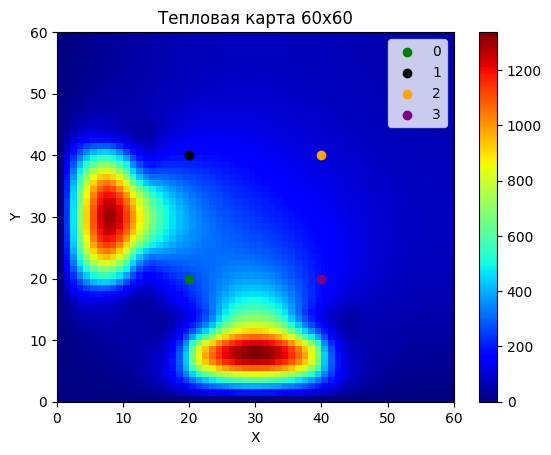

In [9]:
N = 60
dt = 0.25

# фиксированная температура на гранях
fixed_temp(T)

# массивы для отслеживания температур в пробах
probe_values0 = []
probe_values1 = []
probe_values2 = []
probe_values3 = []

# количество шагов по времени (количество итераций)
it_max = int(t / dt)

# основная часть, нагрев пластины от источников
start = time.time()
for it in trange(it_max):
    heat_source(T, x_source0, y_source0, h_source0, w_source0, theta0, p0, it, dt)
    heat_source(T, x_source1, y_source1, h_source1, w_source1, theta1, p1, it, dt)
    abs_thermal_insulation(T)
    diffuse_step_full(N, it, T, dx, dt, Dij)
    
    # запись температур в пробах
    probe_values0.append(T[it % 2-1, y_probe0, x_probe0])
    probe_values1.append(T[it % 2-1, y_probe1, x_probe1])
    probe_values2.append(T[it % 2-1, y_probe2, x_probe2])
    probe_values3.append(T[it % 2-1, y_probe3, x_probe3])
end = time.time() - start

# построение карты
plt.pcolormesh(T[0], cmap='jet')
plt.colorbar()
plt.scatter(x_probe0, y_probe0, label='0', color='green')
plt.scatter(x_probe1, y_probe1, label='1', color='black')
plt.scatter(x_probe2, y_probe2, label='2', color='orange')
plt.scatter(x_probe3, y_probe3, label='3', color='purple')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Тепловая карта 60x60")
plt.legend()

print(f'\nВремя построения: {end} секунд')

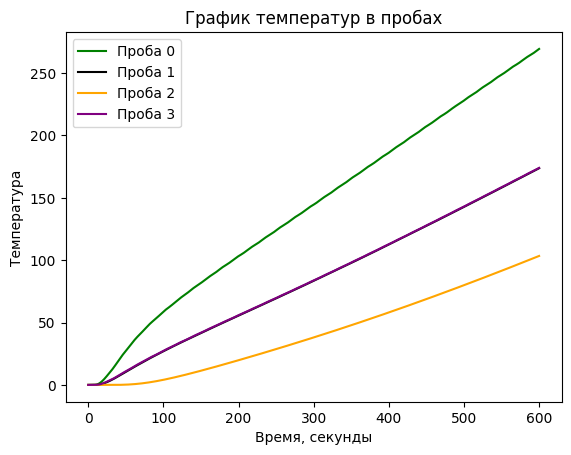

In [10]:
# построение графиков темеператур в пробах
plt.plot(np.arange(it_max) * dt, probe_values0, color='green', label='Проба 0')
plt.plot(np.arange(it_max) * dt, probe_values1, color='black', label='Проба 1')
plt.plot(np.arange(it_max) * dt, probe_values2, color='orange', label='Проба 2')
plt.plot(np.arange(it_max) * dt, probe_values3, color='purple', label='Проба 3')

plt.xlabel("Время, секунды")
plt.ylabel("Температура")
plt.title("График температур в пробах")
plt.legend()

Период температур в пробе 0: [6.00000000e+02 6.66666667e+01 1.93548387e+01 1.76470588e+01
 1.09090909e+01 1.01694915e+01 5.06329114e-01]
Период температур в пробе 1: [600.         100.          10.90909091  10.52631579]
Период температур в пробе 2: [300.           0.50420168]
Период температур в пробе 3: [600.          85.71428571  19.35483871  18.18181818]


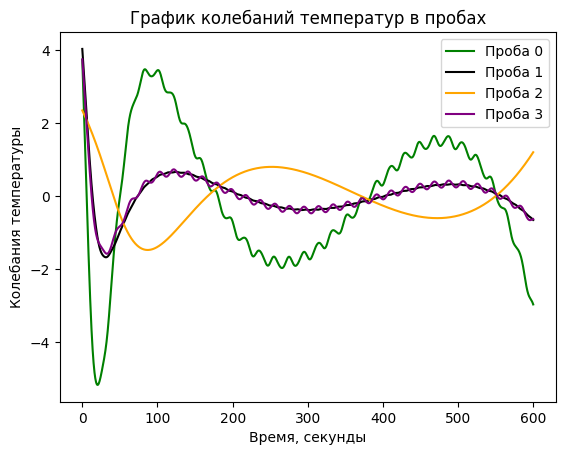

In [12]:
# нахождение периода температуры температуры в пробах
# полиномами 3-ей степени приближаем точки
coef0 = np.polyfit(np.arange(it_max) * dt, probe_values0, 3)
coef1 = np.polyfit(np.arange(it_max) * dt, probe_values1, 3)
coef2 = np.polyfit(np.arange(it_max) * dt, probe_values2, 3)
coef3 = np.polyfit(np.arange(it_max) * dt, probe_values3, 3)

# ищем разницу температур в точках
dif_probe0 = probe_values0 - np.polyval(coef0, np.arange(it_max) * dt)
dif_probe1 = probe_values1 - np.polyval(coef1, np.arange(it_max) * dt)
dif_probe2 = probe_values2 - np.polyval(coef2, np.arange(it_max) * dt)
dif_probe3 = probe_values3 - np.polyval(coef3, np.arange(it_max) * dt)

# строим графики колебаний
plt.plot(np.arange(it_max) * dt, dif_probe0, color='green', label='Проба 0')
plt.plot(np.arange(it_max) * dt, dif_probe1, color='black', label='Проба 1')
plt.plot(np.arange(it_max) * dt, dif_probe2, color='orange', label='Проба 2')
plt.plot(np.arange(it_max) * dt, dif_probe3, color='purple', label='Проба 3')

plt.xlabel("Время, секунды")
plt.ylabel("Колебания температуры")
plt.title("График колебаний температур в пробах")
plt.legend()

# ищем периоды колебаний
fourier = np.fft.rfft(dif_probe0)
freq_ = np.fft.rfftfreq(len(dif_probe0), d=dt)
peak_, _ = signal.find_peaks(fourier)
print(f'Период температур в пробе 0: {1 / freq_[peak_]}')

fourier = np.fft.rfft(dif_probe1)
freq_ = np.fft.rfftfreq(len(dif_probe1), d=dt)
peak_, _ = signal.find_peaks(fourier)
print(f'Период температур в пробе 1: {1 / freq_[peak_]}')

fourier = np.fft.rfft(dif_probe2)
freq_ = np.fft.rfftfreq(len(dif_probe2), d=dt)
peak_, _ = signal.find_peaks(fourier)
print(f'Период температур в пробе 2: {1 / freq_[peak_]}')

fourier = np.fft.rfft(dif_probe3)
freq_ = np.fft.rfftfreq(len(dif_probe3), d=dt)
peak_, _ = signal.find_peaks(fourier)
print(f'Период температур в пробе 3: {1 / freq_[peak_]}')

Для того, чтобы восстановить периоды колебаний температуры в местах установки проб:

1. Сначала для температуры в пробах мы применим преобразование Фурье с помощью `np.fft.rfft`.
2. Затем найдем частоты дискретизации дискретного преобразования Фурье с помощью `np.fft.rfftfreq`.
3. Необходимо найти локальные экстремумы (сигналы, пики), у полученных с помощью преобразования Фурье данных, с помощью `scipy.signal.find_peaks`.
4. Итоговым результатом будет число обратное к частоте, то есть $T=\frac{1}{\nu}$, где $\nu$ - частота.

# Основная задача
Построили карту для N=60, теперь обобщим задачу на все N.$$$$

Сперва напишем функцию для записи темепературы проб и карты в файл. Она же будет выводить время моделирования карты.

In [13]:
def write_in_file(N: int, dt: float, L: int = 60):
    """
    Главная функция, которая записывает в файл тепловую карту, 
    темепературу в пробах в конечный момент времени и карту диффузии
    N - размерность поля темеператур
    L - размерность исходной пластины
    dt - шаг по времени
    """
    # Инициализируем поле температур T,
    # в момент времени t = 0 T = 0
    T = np.zeros((2, N, N))

    # шаг по карте
    dx = L / N
    
    hx = int(10 / dx)
    # карта коеффициентов диффузии
    Dij = np.full((N, N), D0)
    
    # коеффициенты диффузии у белых полей
    # всего 4 белых поля
    Dij[hx//2 + hx:2*hx, hx//2:hx//2 + hx] = D1
    Dij[2*hx:2*hx + hx//2, hx:hx + hx//2] = D1
    Dij[3*hx + hx//2:4*hx, hx:hx + hx//2] = D1
    Dij[4*hx:4*hx + hx//2, hx//2:hx//2 + hx] = D1

    Dij[hx//2:hx//2 + hx, hx//2 + hx:2*hx] = D1
    Dij[hx:hx + hx//2, 2*hx:2*hx + hx//2] = D1
    Dij[hx:hx + hx//2, 3*hx + hx//2:4*hx] = D1
    Dij[hx//2:hx//2 + hx, 4*hx:4*hx + hx//2] = D1
    
    # все источники имеют прямоугольную форму и одинаковый размер
    # 20мм x 5мм
    h_source0 = int(20 / dx)
    w_source0 = int(5 / dx)

    h_source1 = w_source0
    w_source1 = h_source0
    # координаты нижней грани источника 0
    y_source0 = int(20 / dx)
    x_source0 = int(5 / dx)

    # координаты нижней грани источника 1
    y_source1 = int(5 / dx)
    x_source1 = int(20 / dx)

    # координаты всех проб
    x_probe0 = int(20 / dx)
    y_probe0 = int(20 / dx)
    
    x_probe1 = int(20 / dx)
    y_probe1 = int(40 / dx)

    x_probe2 = int(40 / dx)
    y_probe2 = int(40 / dx)

    x_probe3 = int(40 / dx)
    y_probe3 = int(20 / dx)
    
    #C = 0.25
    #dt = 0.02
    probe_values0 = []
    probe_values1 = []
    probe_values2 = []
    probe_values3 = []
    fixed_temp(T)
    it_max = int(t / dt)

    start = time.time()
    for it in trange(it_max):
        heat_source(T, x_source0, y_source0, h_source0, w_source0, theta0, p0, it, dt)
        heat_source(T, x_source1, y_source1, h_source1, w_source1, theta1, p1, it, dt)
        abs_thermal_insulation(T)
        diffuse_step_full(N, it, T, dx, dt, Dij)

        probe_values0.append(T[(it+1)%2, y_probe0, x_probe0])
        probe_values1.append(T[(it+1)%2, y_probe1, x_probe1])
        probe_values2.append(T[(it+1)%2, y_probe2, x_probe2])
        probe_values3.append(T[(it+1)%2, y_probe3, x_probe3])
    end = time.time() - start
    print(f'\nВремя построения тепловой карты: {end} секунд\n')
    probe = [probe_values0,probe_values1,probe_values2,probe_values3]
    # запись температурного поля в бинарный файл
    # с помощбю numpy
    with open(f'/Users/kirill/edu/3course/CP3/HW_2/files/T_field/Temp_field{N}.npy', 'wb') as f:
        np.save(f, T)
    f.close()
        
    # запись температуры проб в текстовый файл
    for i in range(4):
        with open(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_{i}/temp_probe{N}.txt', 'w+') as f:
            for items in probe[i]:
                f.write('%s\n' %items)
        f.close()
    
    # запись карты коеффициентов диффузии в файл
    # с помощбю numpy
    with open(f'/Users/kirill/edu/3course/CP3/HW_2/files/Diff_field/diffusion_field{N}.npy', 'wb') as f:
        np.save(f, Dij)
    f.close()

In [14]:
def read_probe_from_file(path: str) -> list:
    """
    Читаем темпеературу проб из файла
    path - путь до файла
    """
    probe = []
    f = open(path, 'r')
    for x in f.readlines():
        if x:
            probe.append(float(x))
    f.close()
    
    return probe

In [15]:
def probes_graphs(T: np.ndarray,
                  Dij: np.ndarray,
                  probe0: list,
                  probe1: list,
                  probe2: list,
                  probe3: list,
                  N: int
                 ):
    """
    Функция для построения тепловой карты,
    поля диффузии и графиков тепмпературы проб
    """
    dx = L/N
    it_max = int(600 / dt)
    h_source0 = int(20 / dx)
    w_source0 = int(5 / dx)

    h_source1 = w_source0
    w_source1 = h_source0
    # координаты нижней грани источника 0
    y_source0 = int(20 / dx)
    x_source0 = int(5 / dx)

    # координаты нижней грани источника 1
    y_source1 = int(5 / dx)
    x_source1 = int(20 / dx)

    # координаты всех проб
    x_probe0 = int(20 / dx)
    y_probe0 = int(20 / dx)
    
    x_probe1 = int(20 / dx)
    y_probe1 = int(40 / dx)

    x_probe2 = int(40 / dx)
    y_probe2 = int(40 / dx)

    x_probe3 = int(40 / dx)
    y_probe3 = int(20 / dx)
    
    # поле температур, с точками проб
    plt.figure()
    plt.pcolormesh(T[0], cmap='jet')
    plt.colorbar()
    plt.scatter(x_probe0, y_probe0, label='Проба 0', color='green')
    plt.scatter(x_probe1, y_probe1, label='Проба 1', color='black')
    plt.scatter(x_probe2, y_probe2, label='Проба 2', color='orange')
    plt.scatter(x_probe3, y_probe3, label='Проба 3', color='purple')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Тепловая карта {N}x{N}")
    plt.legend()
    
    # поле диффузии
    plt.figure()
    plt.pcolormesh(Dij)
    plt.colorbar()
    #plt.axis('equal')
    plt.title("Карта коеффициентов диффузии")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    # график темеператур в пробах
    plt.figure()
    plt.plot(np.arange(it_max) * dt, probe_values0, color='green', label='Проба 0')
    plt.plot(np.arange(it_max) * dt, probe_values1, color='black', label='Проба 1')
    plt.plot(np.arange(it_max) * dt, probe_values2, color='orange', label='Проба 2')
    plt.plot(np.arange(it_max) * dt, probe_values3, color='purple', label='Проба 3')
    plt.xlabel("Время, секунды")
    plt.ylabel("Температура")
    plt.title("График температур в пробах")
    plt.legend()

In [27]:
def probe_temp_periods(probe_values0: list,
                       probe_values1: list,
                       probe_values2: list,
                       probe_values3: list,
                       dt: float):
    """
    Функция ищет периоды температуры в пробах,
    стороит график колебаний
    probe_valuesN - темепературы в пробе N в каждый момент времени
    dt - шаг по времени
    """
    # нахождение периода температуры температуры в пробах
    # полиномами 3-ей степени приближаем точки
    it_max = int(600 / dt)
    p0 = np.polyfit(np.arange(it_max) * dt, probe_values0, 3)
    p1 = np.polyfit(np.arange(it_max) * dt, probe_values1, 3)
    p2 = np.polyfit(np.arange(it_max) * dt, probe_values2, 3)
    p3 = np.polyfit(np.arange(it_max) * dt, probe_values3, 3)

    # ищем разницу температур в точках
    dif_probe0 = probe_values0 - np.polyval(p0, np.arange(it_max) * dt)
    dif_probe1 = probe_values1 - np.polyval(p1, np.arange(it_max) * dt)
    dif_probe2 = probe_values2 - np.polyval(p2, np.arange(it_max) * dt)
    dif_probe3 = probe_values3 - np.polyval(p3, np.arange(it_max) * dt)

    # строим графики колебаний
    plt.plot(np.arange(it_max) * dt, dif_probe0, color='green', label='Проба 0')
    plt.plot(np.arange(it_max) * dt, dif_probe1, color='black', label='Проба 1')
    plt.plot(np.arange(it_max) * dt, dif_probe2, color='orange', label='Проба 2')
    plt.plot(np.arange(it_max) * dt, dif_probe3, color='purple', label='Проба 3')

    plt.xlabel("Время, секунды")
    plt.ylabel("Колебания температуры")
    plt.title("График колебаний температур в пробах")
    plt.legend()

    # ищим периоды колебаний
    fourier = np.fft.rfft(dif_probe0)
    freq_ = np.fft.rfftfreq(len(dif_probe0), d=dt)
    peak_, _ = signal.find_peaks(fourier)
    peak_ = peak_[:5]
    print(f'Период температур в пробе 0: {1 / freq_[peak_]}')

    fourier = np.fft.rfft(dif_probe1)
    freq_ = np.fft.rfftfreq(len(dif_probe1), d=dt)
    peak_, _ = signal.find_peaks(fourier)
    peak_ = peak_[:5]
    print(f'Период температур в пробе 1: {1 / freq_[peak_]}')

    fourier = np.fft.rfft(dif_probe2)
    freq_ = np.fft.rfftfreq(len(dif_probe2), d=dt)
    peak_, _ = signal.find_peaks(fourier)
    peak_ = peak_[:5]
    print(f'Период температур в пробе 2: {1 / freq_[peak_]}')

    fourier = np.fft.rfft(dif_probe3)
    freq_ = np.fft.rfftfreq(len(dif_probe3), d=dt)
    peak_, _ = signal.find_peaks(fourier)
    peak_ = peak_[:5]
    print(f'Период температур в пробе 3: {1 / freq_[peak_]}')

# N = 60

100%|████████████████████████████████████| 2400/2400 [00:00<00:00, 10458.37it/s]



Время построения тепловой карты: 0.2313518524169922 секунд



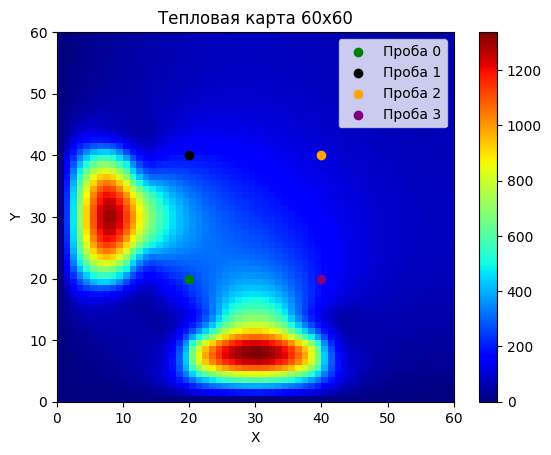

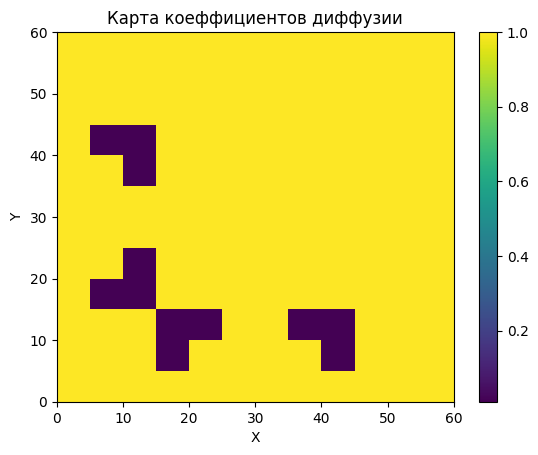

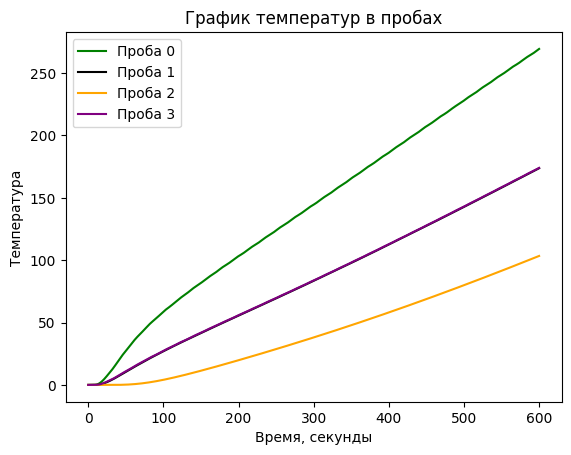

In [17]:
N = 60
write_in_file(N, dt=0.25)

T = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/T_field/Temp_field{N}.npy')
Diff = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/Diff_field/diffusion_field{N}.npy')

probe_0 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_0/temp_probe{N}.txt')
probe_1 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_1/temp_probe{N}.txt')
probe_2 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_2/temp_probe{N}.txt')
probe_3 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_3/temp_probe{N}.txt')

probes_graphs(T, Diff, probe_0, probe_1, probe_2, probe_3, N=60)

Период температур в пробе 0: [600.          66.66666667  19.35483871  17.64705882  10.90909091]
Период температур в пробе 1: [600.         100.          10.90909091  10.52631579]
Период температур в пробе 2: [300.           0.50420168]
Период температур в пробе 3: [600.          85.71428571  19.35483871  18.18181818]


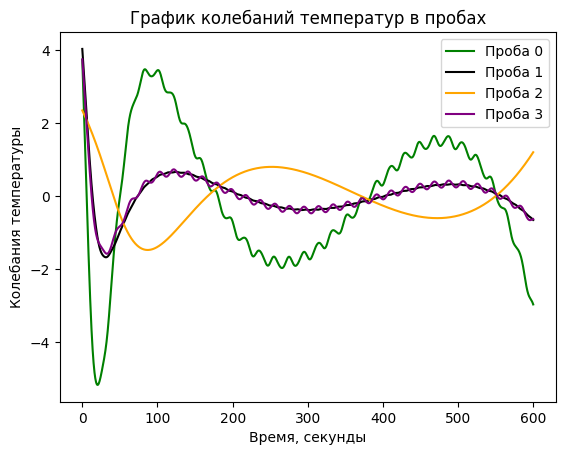

In [18]:
probe_temp_periods(probe_0, probe_1, probe_2, probe_3, dt=0.25)

# N = 120

100%|██████████████████████████████████| 20000/20000 [00:01<00:00, 10559.14it/s]



Время построения тепловой карты: 1.8962178230285645 секунд



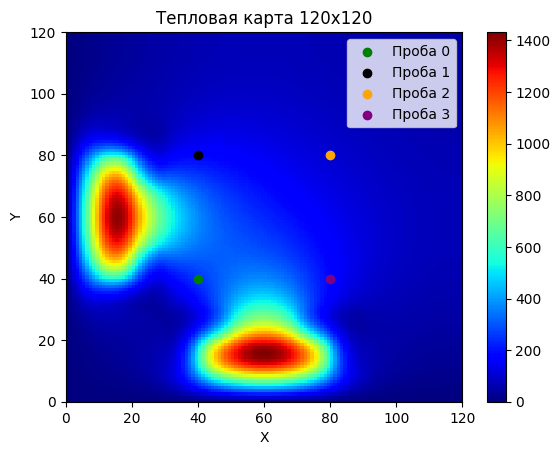

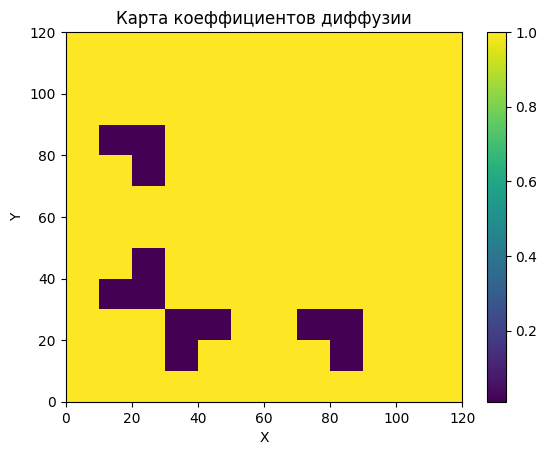

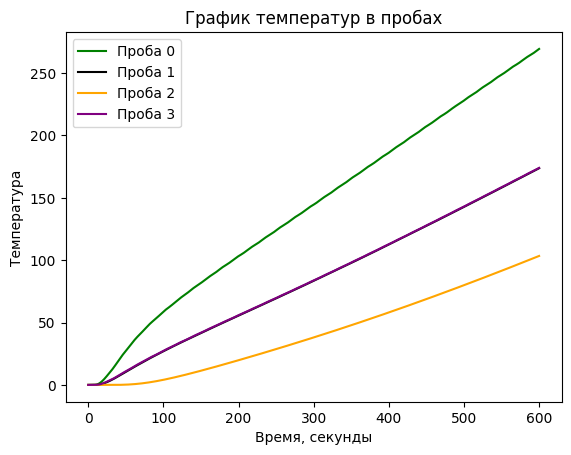

In [19]:
N = 120
write_in_file(N, dt=0.03)

T = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/T_field/Temp_field{N}.npy')
Diff = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/Diff_field/diffusion_field{N}.npy')
probe_0 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_0/temp_probe{N}.txt')
probe_1 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_1/temp_probe{N}.txt')
probe_2 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_2/temp_probe{N}.txt')
probe_3 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_3/temp_probe{N}.txt')

probes_graphs(T, Diff, probe_0, probe_1, probe_2, probe_3, N)

Период температур в пробе 0: [600.  75.]
Период температур в пробе 1: [600. 100.]
Период температур в пробе 2: [300.]
Период температур в пробе 3: [600. 100.]


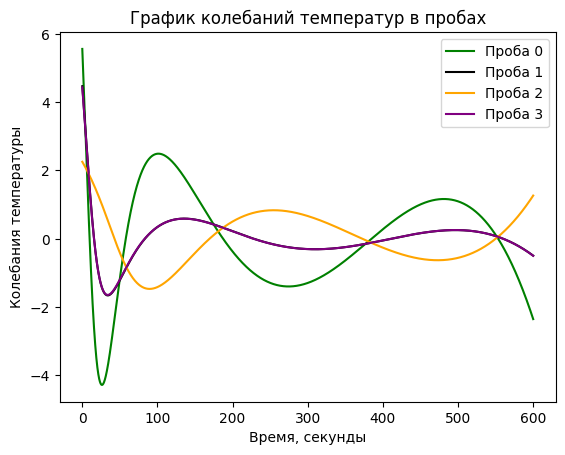

In [20]:
probe_temp_periods(probe_0, probe_1, probe_2, probe_3, dt=0.03)

# N = 240

100%|███████████████████████████████████| 60000/60000 [00:08<00:00, 7486.99it/s]



Время построения тепловой карты: 8.015621185302734 секунд



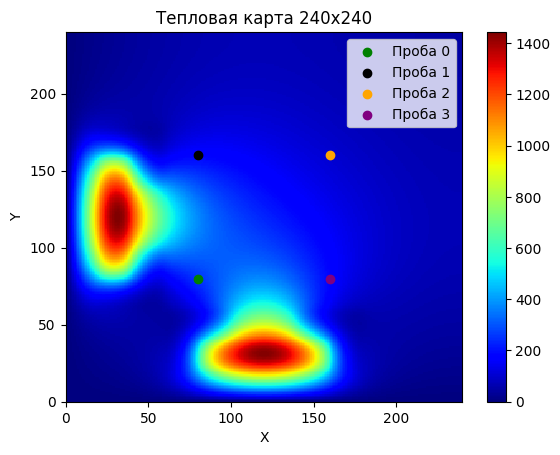

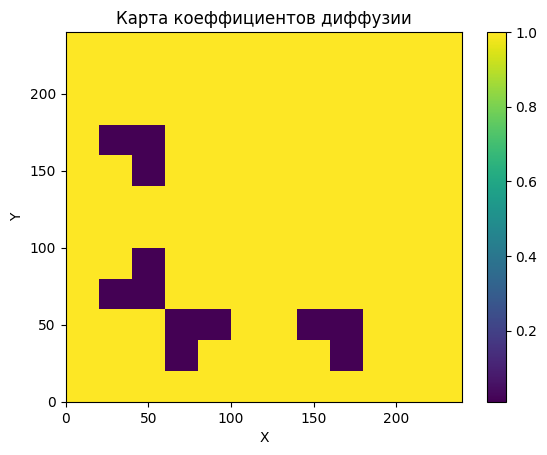

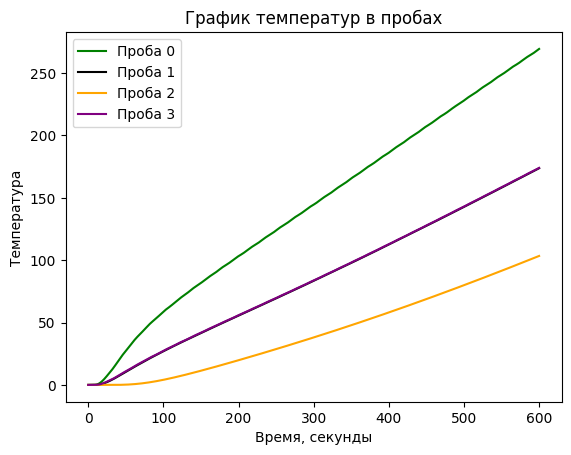

In [21]:
N = 240
write_in_file(N, dt=0.01)

T = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/T_field/Temp_field{N}.npy')
Diff = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/Diff_field/diffusion_field{N}.npy')
probe_0 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_0/temp_probe{N}.txt')
probe_1 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_1/temp_probe{N}.txt')
probe_2 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_2/temp_probe{N}.txt')
probe_3 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_3/temp_probe{N}.txt')

probes_graphs(T, Diff, probe_0, probe_1, probe_2, probe_3, N)

Период температур в пробе 0: [600.          85.71428571]
Период температур в пробе 1: [600. 100.]
Период температур в пробе 2: [300.]
Период температур в пробе 3: [600. 100.]


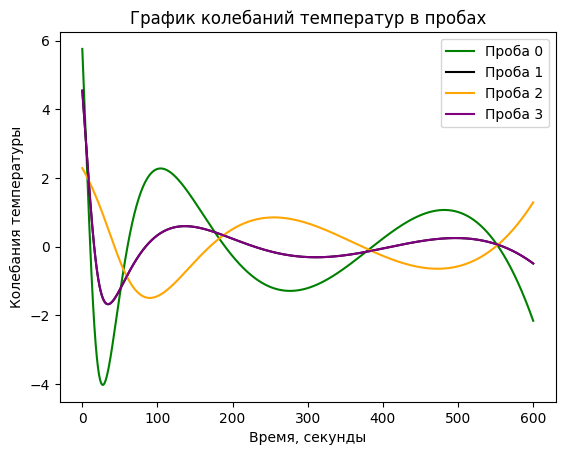

In [22]:
probe_temp_periods(probe_0, probe_1, probe_2, probe_3, dt=0.01)

# N = 480

100%|█████████████████████████████████| 200000/200000 [00:47<00:00, 4249.98it/s]



Время построения тепловой карты: 47.06097888946533 секунд



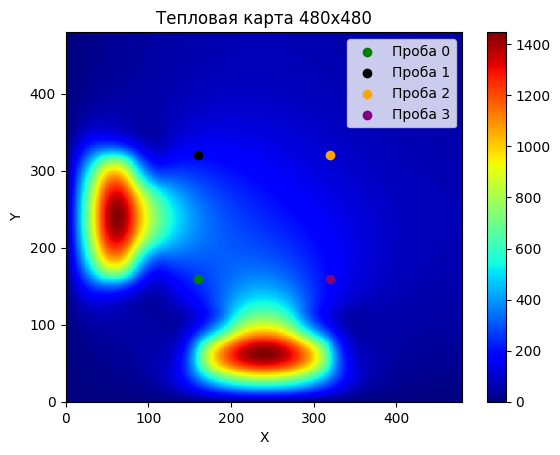

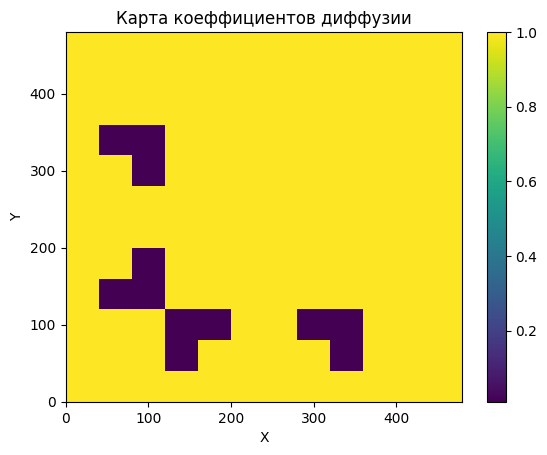

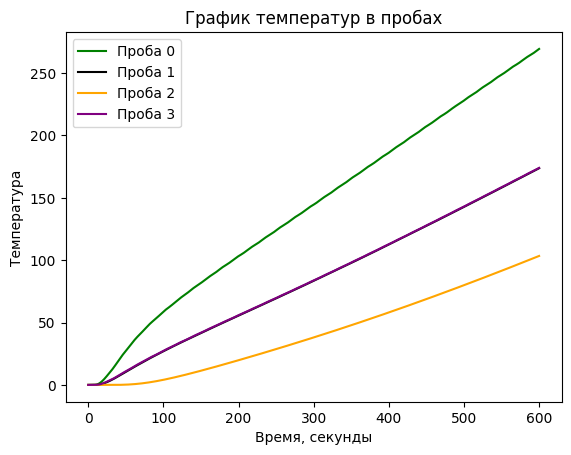

In [23]:
N = 480
write_in_file(N, dt=0.003)

T = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/T_field/Temp_field{N}.npy')
Diff = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/Diff_field/diffusion_field{N}.npy')
probe_0 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_0/temp_probe{N}.txt')
probe_1 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_1/temp_probe{N}.txt')
probe_2 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_2/temp_probe{N}.txt')
probe_3 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_3/temp_probe{N}.txt')

probes_graphs(T, Diff, probe_0, probe_1, probe_2, probe_3, N)

Период температур в пробе 0: [6.00000000e+02 8.57142857e+01 6.04832613e-03 6.00306156e-03
 6.00258111e-03]
Период температур в пробе 1: [6.00000000e+02 1.00000000e+02 6.04832613e-03 6.00294144e-03
 6.00270122e-03]
Период температур в пробе 2: [3.00000000e+02 6.04844807e-03 6.04832613e-03 6.04820419e-03
 6.01069904e-03]
Период температур в пробе 3: [6.00000000e+02 1.00000000e+02 6.04832613e-03 6.00318169e-03
 6.00234091e-03]


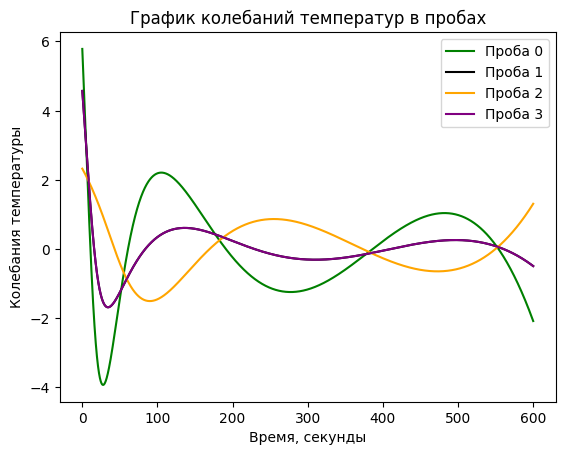

In [24]:
probe_temp_periods(probe_0, probe_1, probe_2, probe_3, dt=0.003)

# N = 960

100%|███████████████████████████████| 1200000/1200000 [15:40<00:00, 1276.10it/s]



Время построения тепловой карты: 940.3653590679169 секунд



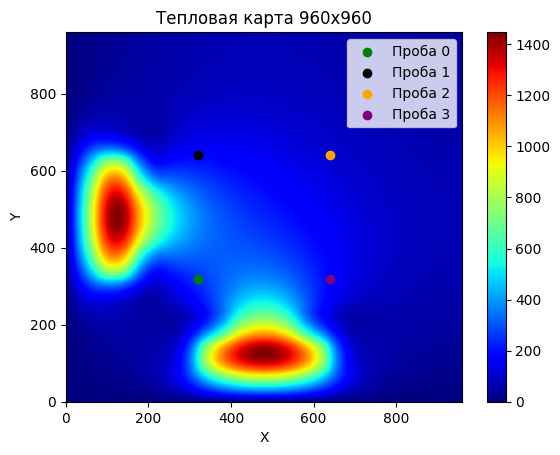

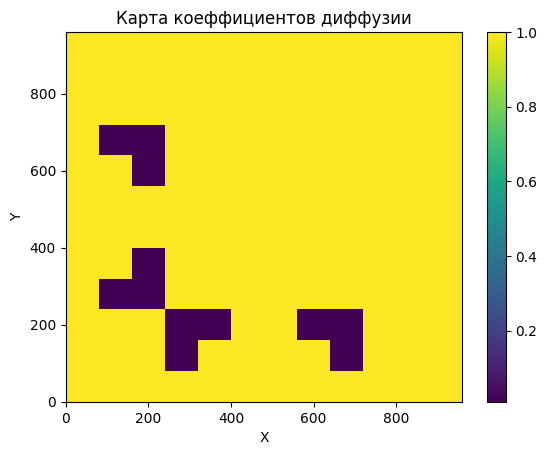

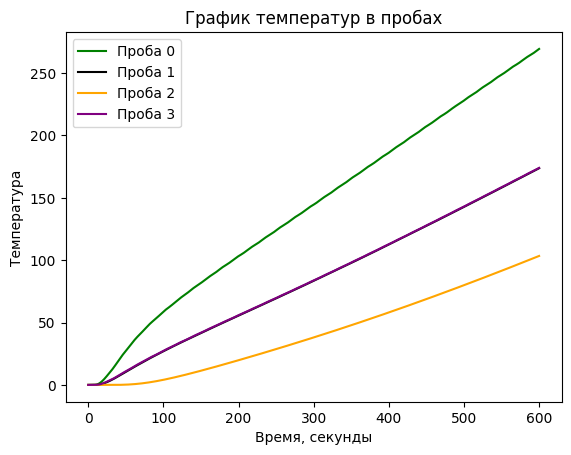

In [25]:
N = 960
write_in_file(N, dt=0.0005)

T = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/T_field/Temp_field{N}.npy')
Diff = np.load(f'/Users/kirill/edu/3course/CP3/HW_2/files/Diff_field/diffusion_field{N}.npy')
probe_0 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_0/temp_probe{N}.txt')
probe_1 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_1/temp_probe{N}.txt')
probe_2 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_2/temp_probe{N}.txt')
probe_3 = read_probe_from_file(f'/Users/kirill/edu/3course/CP3/HW_2/files/probe_3/temp_probe{N}.txt')

probes_graphs(T, Diff, probe_0, probe_1, probe_2, probe_3, N)

Период температур в пробе 0: [6.00000000e+02 8.57142857e+01 2.40384615e-03 1.52437475e-03
 1.48810262e-03]
Период температур в пробе 1: [6.00000000e+02 1.00000000e+02 2.40384615e-03 1.52437475e-03
 1.48810262e-03]
Период температур в пробе 2: [3.00000000e+02 2.40384615e-03 2.40380763e-03 2.10725951e-03
 2.10722991e-03]
Период температур в пробе 3: [6.00000000e+02 1.00000000e+02 2.40384615e-03 1.52437475e-03
 1.48810262e-03]


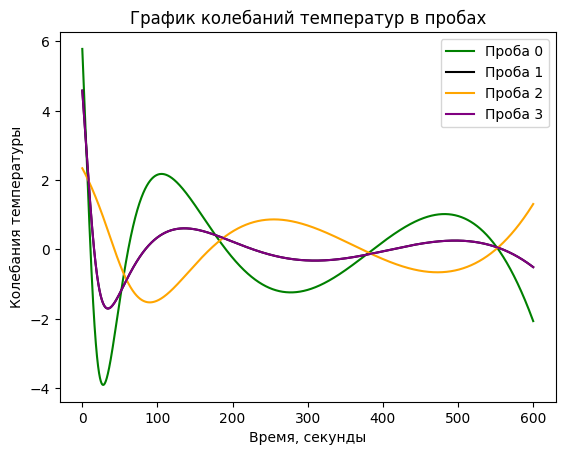

In [26]:
probe_temp_periods(probe_0, probe_1, probe_2, probe_3, dt=0.0005)